In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
import torch
import math
import os
from PIL import Image
import numpy as np
import json

In [34]:
torch.cuda.empty_cache()

In [35]:
# Define transformations for images and masks
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the input images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the masks to match images
    transforms.ToTensor(),  # Convert masks to PyTorch tensors
])

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, image_transforms=None, mask_transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.images = []

        # Filter for image files and ensure corresponding masks exist
        valid_extensions = ['.jpg', '.jpeg', '.png']  # Add or remove extensions as needed
        self.images = [f for f in os.listdir(image_dir) 
                       if any(f.endswith(ext) for ext in valid_extensions)
                       and os.path.exists(os.path.join(mask_dir, f"{f}"))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_filename = self.images[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        mask_filename = f"{img_filename}"  # Adjust based on your mask naming convention
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transforms:
            image = self.image_transforms(image)
        if self.mask_transforms:
            mask = self.mask_transforms(mask)

        return image, mask


In [36]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float("inf")
        
    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
        return False

In [37]:
class Callback:
    def __init__(self):
        self.best_val_acc = 0
        self.best_model_state = None

    def check_and_save_best_model(self, model, val_acc):
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.best_model_state = model.state_dict()

    def save_best_model(self, path):
        if self.best_model_state:
            torch.save(self.best_model_state, path)
        else:
            print("No model state to save.")

In [38]:
# Double convolution block
class DoubleConv(nn.Module):
    """(Convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Downsampling block
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Upsampling block
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Output convolution block
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [39]:
class ConvLSTM(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.conv_lstm = nn.LSTMCell(input_size=(in_channels, kernel_size, kernel_size),
                                     hidden_size=(out_channels, kernel_size, kernel_size))

    def forward(self, x, cur_state):
        h_cur, c_cur = self.conv_lstm(x, cur_state)
        return h_cur, c_cur


In [40]:
# U-Net model
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [17]:
# Hyperparameters
learning_rate = 1e-4
batch_size = 1
num_epochs = 50

# Load the full dataset
image_dir = "C:\\Users\\Lionel\\Desktop\\Digital Twin\\Final Images\Total\\Total_cropped"
mask_dir = "C:\\Users\\Lionel\\Desktop\\Digital Twin\\Final Images\\Total\\Total_binary"
full_dataset = SegmentationDataset(image_dir, mask_dir, image_transforms, mask_transforms)

# Split the dataset
total_size = len(full_dataset)
print(total_size)
val_size = int(0.3 * total_size)  # Calculate 30% of the total size for validation
train_size = total_size - val_size  # The rest for training
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Prepare data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, optimizer, and loss function
model = UNet(n_channels=3, n_classes=1).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = BCEWithLogitsLoss()

# Initialize performance metrics
losses = []
accuracies = []
val_losses = []
val_accs = []

# Initialize earlystopper and callback
early_stopper = EarlyStopping(patience=1, min_delta=0)
callback = Callback()

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        total_loss += loss.item()

        # Calculating accuracy
        predicted = torch.sigmoid(outputs) > 0.5  # Convert output probabilities to binary predictions (0 or 1)
        correct_pixels += (predicted == masks).sum().item()
        total_pixels += torch.numel(masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / len(train_dataloader)
    epoch_acc = correct_pixels / total_pixels * 100

    # Append metrics to lists
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    # Validate the results
    val_total_loss = 0
    val_correct_pixels = 0
    val_total_pixels = 0
    with torch.no_grad():
        for val_images, val_masks in val_dataloader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
    
            # Forward pass
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)
            val_total_loss += val_loss.item()
    
            # Calculating accuracy
            val_predicted = torch.sigmoid(val_outputs) > 0.5  # Convert output probabilities to binary predictions (0 or 1)
            val_correct_pixels += (val_predicted == val_masks).sum().item()
            val_total_pixels += torch.numel(val_masks)
    
        val_epoch_loss = val_total_loss / len(val_dataloader)
        val_epoch_acc = val_correct_pixels / val_total_pixels * 100
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, val_Loss: {val_epoch_loss:.4f}, val_acc: {val_epoch_acc:.2f}%")

    # Check and save the best model so far
    callback.check_and_save_best_model(model, val_epoch_acc)

    if early_stopper.early_stop(val_epoch_loss):
        print(f"Early stopped at epoch {epoch+1}")
        break

# Saving the metrics
output_dir = "C:\\Users\\Lionel\\Desktop\\Digital Twin\\Results\\Recurrent U-Net"
os.makedirs(output_dir, exist_ok=True)
metrics = {"loss": losses, "accuracy": accuracies, "val_loss": val_losses, "val_accuracy": val_accs}
metrics_path = 'U_Net_performance_metrics.json'
metrics_dir = os.path.join(output_dir, metrics_path)
with open(metrics_dir, 'w') as f:
    json.dump(metrics, f, indent=4)  

# Save the best model
best_model_path = os.path.join(output_dir, 'best_model.pth')
callback.save_best_model(best_model_path)

# Save optimizer state if needed
optimizer_path = os.path.join(output_dir, 'optimizer.pth')
torch.save(optimizer.state_dict(), optimizer_path)

1347
Epoch [1/50], Loss: 0.1992, Accuracy: 91.98%, val_Loss: 0.1366, val_acc: 93.94%
Epoch [2/50], Loss: 0.1068, Accuracy: 94.94%, val_Loss: 0.0798, val_acc: 95.72%
Epoch [3/50], Loss: 0.0819, Accuracy: 95.61%, val_Loss: 0.0794, val_acc: 95.55%
Epoch [4/50], Loss: 0.0733, Accuracy: 95.83%, val_Loss: 0.0573, val_acc: 96.32%
Epoch [5/50], Loss: 0.0679, Accuracy: 95.98%, val_Loss: 0.0586, val_acc: 96.23%
Epoch [6/50], Loss: 0.0636, Accuracy: 96.07%, val_Loss: 0.0568, val_acc: 96.23%
Epoch [7/50], Loss: 0.0573, Accuracy: 96.31%, val_Loss: 0.0489, val_acc: 96.53%
Epoch [8/50], Loss: 0.0540, Accuracy: 96.41%, val_Loss: 0.0514, val_acc: 96.46%
Epoch [9/50], Loss: 0.0564, Accuracy: 96.33%, val_Loss: 0.0630, val_acc: 96.15%
Early stopped at epoch 9


In [18]:
import torch

def evaluate_model(dataloader, model, device, threshold=0.5):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Initialize counters
    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():
        for images, true_masks in dataloader:
            images = images.to(device)
            true_masks = true_masks.to(device)
            
            # Obtain the model's logits for each image
            logits = model(images)
            
            # Apply sigmoid to convert logits to probabilities
            probs = torch.sigmoid(logits)
            
            # Apply threshold to obtain binary predictions
            preds = probs > threshold
            
            # Flatten the predictions and true values for easier comparison
            preds, true_masks = preds.view(-1), true_masks.view(-1)
            
            # Calculate TP, FP, FN, TN
            TP += ((preds == 1) & (true_masks == 1)).sum().item()
            FP += ((preds == 1) & (true_masks == 0)).sum().item()
            FN += ((preds == 0) & (true_masks == 1)).sum().item()
            TN += ((preds == 0) & (true_masks == 0)).sum().item()

    # Return the confusion matrix components
    return TP, FP, FN, TN


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate on training data
TP_train, FP_train, FN_train, TN_train = evaluate_model(train_dataloader, model, device)
print(f"Training Data - TP: {TP_train}, FP: {FP_train}, FN: {FN_train}, TN: {TN_train}")

# Evaluate on validation data
TP_val, FP_val, FN_val, TN_val = evaluate_model(val_dataloader, model, device)
print(f"Validation Data - TP: {TP_val}, FP: {FP_val}, FN: {FN_val}, TN: {TN_val}")


Training Data - TP: 33078612, FP: 238600, FN: 2033461, TN: 24855898
Validation Data - TP: 14631824, FP: 107665, FN: 771656, TN: 10286790


In [20]:
def calculate_performance_metrics(TP, FP, FN, TN):
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else 0
    dice_coefficient = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0
    jaccard_index = TP / (TP + FP + FN) if (TP + FP + FN) else 0
    
    return precision, recall, accuracy, dice_coefficient, jaccard_index


precision, recall, accuracy, dice_coefficient, jaccard_index = calculate_performance_metrics(TP_val, FP_val, FN_val, TN_val)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Dice Coefficient (F1 Score): {dice_coefficient*100:.2f}%")
print(f"Jaccard Index (IoU): {jaccard_index*100:.2f}%")


Accuracy: 96.59%
Precision: 99.27%
Recall: 94.99%
Dice Coefficient (F1 Score): 97.08%
Jaccard Index (IoU): 94.33%


In [41]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np

best_model_path = "..\\Results\\Recurrent U-Net\\best_model.pth"
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, optimizer, and loss function
model = UNet(n_channels=3, n_classes=1).to(device)
model.load_state_dict(torch.load(best_model_path))

def predict_and_save(image_dir, mask_dir, output_dir, model):
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to the input size expected by the model
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
    ])

    # If using a GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over all images in the directory
    for image_name in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_name)
        mask_path = os.path.join(mask_dir, image_name)
        
        if os.path.isfile(image_path) and image_path.lower().endswith(('png', 'jpg', 'jpeg')):
            # Load and transform the image
            image = Image.open(image_path)
            input_image = transform(image).unsqueeze(0)  # Add batch dimension
            input_image = input_image.to(device)

            with torch.no_grad():  # No need to track gradients
                output = model(input_image)
                mask = torch.sigmoid(output)  # Apply sigmoid to get probabilities
                mask = (mask > 0.5).float()  # Threshold the probabilities to get binary mask

            # Move the mask to CPU
            mask = mask.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU

            # Convert original image to numpy array
            original_image_np = np.array(image.resize((256, 256)))

            # Apply mask: masked part in black, unmasked part in RGB
            masked_image_np = original_image_np * np.expand_dims(mask, axis=-1)
            masked_image_np = masked_image_np.astype(np.uint8)

            # Convert numpy array back to PIL image
            masked_image = Image.fromarray(masked_image_np)

            # Save the masked image to the output directory
            masked_image_output_path = os.path.join(output_dir, image_name)
            masked_image.save(masked_image_output_path)
    print("DONE")

# Usage
image_dir = "C:\\Users\\Lionel\\Desktop\\Digital Twin\\Final Images\\Total\\Total_cropped"
mask_dir = "C:\\Users\\Lionel\\Desktop\\Digital Twin\\Final Images\\Total\\Total_binary"
output_dir  = "C:\\Users\\Lionel\\Desktop\\Digital Twin\\Processed\\Prediction\\original\\Recurrent U-Net"

# Assuming 'model' is your pre-trained model
predict_and_save(image_dir, mask_dir, output_dir, model)

torch.cuda.empty_cache()


DONE


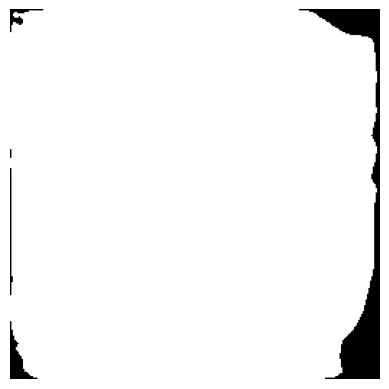

In [8]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Load your image
image_path = "/Users/lionel/Desktop/Research/Processed_Original_cropped_size/T_rgb_20231216_194953_17.png"
image = Image.open(image_path)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the input size expected by the model
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Apply transformations
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Assuming model is your pre-trained model
model.eval()  # Set the model to evaluation mode

# If using a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
input_image = input_image.to(device)

with torch.no_grad():  # No need to track gradients
    output = model(input_image)
    mask = torch.sigmoid(output)  # Apply sigmoid to get probabilities
    mask = (mask > 0.5).float()  # Threshold the probabilities to get binary mask


# Move the mask to CPU and convert to a PIL image
mask = mask.squeeze().cpu()  # Remove batch dimension and move to CPU
mask_image = transforms.ToPILImage()(mask)

# Display the mask using matplotlib
import matplotlib.pyplot as plt

plt.imshow(mask_image, cmap='gray')  # Display the mask
plt.axis('off')  # No axes for cleaner visualization
plt.show()

# Or save the mask to a file
mask_image.save('/Users/lionel/Desktop/Research/duplicate library/test/test5_R_U-Net.png')


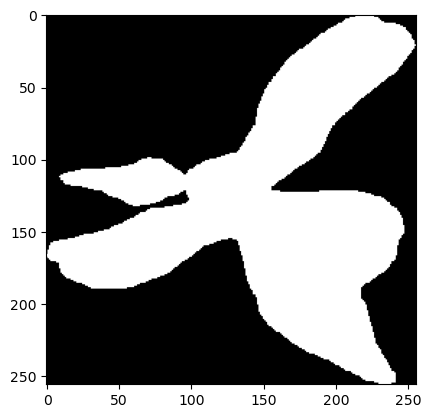

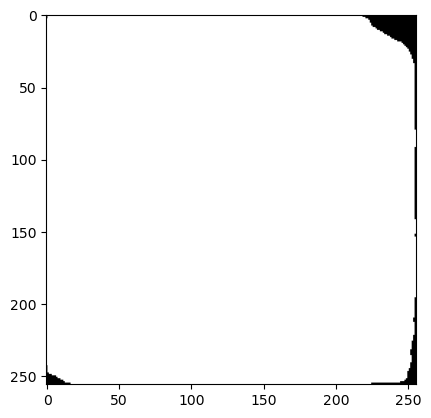

In [15]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# Load your image
image_path = "/Users/lionel/Desktop/Research/Original_cropped_size/T_rgb_20231119_185737_13.png"
mask_path = "/Users/lionel/Desktop/Research/Masked_cropped/binary_T_rgb_20231119_185737_13.png"
image = Image.open(image_path)
mask = Image.open(mask_path).resize((256,256))
plt.imshow(mask)
plt.show()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the input size expected by the model
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Apply transformations
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Assuming model is your pre-trained model
model.eval()  # Set the model to evaluation mode

# If using a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
input_image = input_image.to(device)

with torch.no_grad():  # No need to track gradients
    output = model(input_image)
    mask = torch.sigmoid(output)  # Apply sigmoid to get probabilities
    mask = (mask > 0.5).float()  # Threshold the probabilities to get binary mask


# Move the mask to CPU and convert to a PIL image
mask = mask.squeeze().cpu()  # Remove batch dimension and move to CPU
mask_image = transforms.ToPILImage()(mask)

# Display the mask using matplotlib
import matplotlib.pyplot as plt

plt.imshow(mask_image, cmap='gray')  # Display the mask
#plt.axis('off')  # No axes for cleaner visualization
plt.show()

# Or save the mask to a file
mask_image.save('/Users/lionel/Desktop/Research/duplicate library/test/test6_R_U-Net.png')


In [9]:
import torch

def evaluate_model(dataloader, model, device, threshold=0.5):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Initialize counters
    TP = 0
    FP = 0
    FN = 0
    TN = 0

    with torch.no_grad():
        for images, true_masks in dataloader:
            images = images.to(device)
            true_masks = true_masks.to(device)
            
            # Obtain the model's logits for each image
            logits = model(images)
            
            # Apply sigmoid to convert logits to probabilities
            probs = torch.sigmoid(logits)
            
            # Apply threshold to obtain binary predictions
            preds = probs > threshold
            
            # Flatten the predictions and true values for easier comparison
            preds, true_masks = preds.view(-1), true_masks.view(-1)
            
            # Calculate TP, FP, FN, TN
            TP += ((preds == 1) & (true_masks == 1)).sum().item()
            FP += ((preds == 1) & (true_masks == 0)).sum().item()
            FN += ((preds == 0) & (true_masks == 1)).sum().item()
            TN += ((preds == 0) & (true_masks == 0)).sum().item()

    # Return the confusion matrix components
    return TP, FP, FN, TN


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate on training data
TP_train, FP_train, FN_train, TN_train = evaluate_model(train_dataloader, model, device)
print(f"Training Data - TP: {TP_train}, FP: {FP_train}, FN: {FN_train}, TN: {TN_train}")

# Evaluate on validation data
TP_val, FP_val, FN_val, TN_val = evaluate_model(val_dataloader, model, device)
print(f"Validation Data - TP: {TP_val}, FP: {FP_val}, FN: {FN_val}, TN: {TN_val}")


Training Data - TP: 11900420, FP: 283256, FN: 267787, TN: 8289012
Validation Data - TP: 5091450, FP: 125643, FN: 121458, TN: 3467659


In [12]:
def calculate_performance_metrics(TP, FP, FN, TN):
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) else 0
    dice_coefficient = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0
    jaccard_index = TP / (TP + FP + FN) if (TP + FP + FN) else 0
    
    return precision, recall, accuracy, dice_coefficient, jaccard_index


precision, recall, accuracy, dice_coefficient, jaccard_index = calculate_performance_metrics(TP_val, FP_val, FN_val, TN_val)

print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Dice Coefficient (F1 Score): {dice_coefficient*100:.2f}%")
print(f"Jaccard Index (IoU): {jaccard_index*100:.2f}%")


Precision: 97.59%
Recall: 97.67%
Accuracy: 97.19%
Dice Coefficient (F1 Score): 97.63%
Jaccard Index (IoU): 95.37%
